In [3]:
%matplotlib inline
import matplotlib.pyplot as plt           # Allows to do plots
import fenics as fe                       # Allors to use the FEniCS functions
import os                                 # Allows to use path
import pandas as pd                       # Allows to use data in tables
from IPython.display import display, clear_output
from scipy.interpolate import interp1d
from scipy.optimize import minimize, fmin
import numpy as np

In [4]:
# ----------------------------------------------------------------------------
# Functions definition
# ----------------------------------------------------------------------------        
        
def CompressibleNeoHookean(Mu, Lambda, Ic, J):
        
    Psi = (Mu/2)*(Ic - 3) - Mu*fe.ln(J) + (Lambda/2)*(fe.ln(J))**2
    
    return Psi
    
def CompressibleOgden(Mu, Alpha, D, C, Ic, J):
    
    # Invariant of Right Cauchy-Green deformation tensor
    def I1(C):
        return fe.tr(C)

    def I2(C):
        c1 = C[0,0]*C[1,1] + C[0,0]*C[2,2] + C[1,1]*C[2,2]
        c2 = C[0,1]*C[0,1] + C[0,2]*C[0,2] + C[1,2]*C[1,2]
        return c1 - c2

    def I3(C):
        return fe.det(C)

    # Define function necessary for eigenvalues computation
    def v_inv(C):
        return (I1(C)/3.)**2 - I2(C)/3.

    def s_inv(C):
        return (I1(C)/3.)**3 - I1(C)*I2(C)/6. + I3(C)/2.

    def phi_inv(C):
        arg = s_inv(C)/v_inv(C)*fe.sqrt(1./v_inv(C))
        # numerical issues if arg~0
        # https://fenicsproject.org/qa/12299
        # /nan-values-when-computing-arccos-1-0-bug/
        arg_cond = fe.conditional( fe.ge(arg, 1-fe.DOLFIN_EPS),
        1-fe.DOLFIN_EPS,fe.conditional( fe.le(arg, -1+fe.DOLFIN_EPS),
        -1+fe.DOLFIN_EPS, arg ))
        return fe.acos(arg_cond)/3.

    # Eigenvalues of the strech tensor C
    lambda_1 = Ic/3. + 2*fe.sqrt(v_inv(C))*fe.cos(phi_inv(C))
    lambda_2 = Ic/3. - 2*fe.sqrt(v_inv(C))*fe.cos(fe.pi/3. + phi_inv(C))
    lambda_3 = Ic/3. - 2*fe.sqrt(v_inv(C))*fe.cos(fe.pi/3. - phi_inv(C))

    # Constitutive model
    Psi = 2 * Mu * (J**(-1/3)*lambda_1**(Alpha/2.) +  J**(-1/3)*lambda_2**(Alpha/2.) +  J**(-1/3)*lambda_3**(Alpha/2.) - 3) / Alpha**2 + 1/D * (J-1)**2
        
    return Psi
        
    
    
def LoadCase(LoadCase, FinalRelativeStretch, RelativeStepSize, Dimensions):
    
    Normal = fe.Constant((0, 0, 1))                                                 # Normal to moving side
    
    if LoadCase == 'Compression':
        InitialState = 1
        u_0 = fe.Constant((0, 0, 1E-6))                                             # Little displacement to avoid NaN values
        u_1 = fe.Expression(('0', '0', '(s-1)*h'), degree=1, s = InitialState, h = Dimensions[2] )        # Displacement imposed
        Dir = fe.Constant((0,0,1))                                                  # Deformation direction
        NumberSteps = FinalRelativeStretch / RelativeStepSize                       # Number of steps
        DeltaStretch = -RelativeStepSize
        
    elif LoadCase == 'Tension':
        InitialState = 1
        u_0 = fe.Constant((0, 0, -1E-6))                                            # Little displacement to avoid NaN values
        u_1 = fe.Expression(('0', '0', '(s-1)*h'), degree=1, s = InitialState, h = Dimensions[2] )        # Displacement imposed
        Dir = fe.Constant((0,0,1))                                                  # Deformation direction
        NumberSteps = FinalRelativeStretch / RelativeStepSize                       # Number of steps
        DeltaStretch = RelativeStepSize
        
    elif LoadCase == 'Simple Shear':
        InitialState = 0
        u_0 = fe.Constant((-1E-6, 0, 0))                                            # Little displacement to avoid NaN values
        u_1 = fe.Expression(('s*h', '0', '0'), degree=1, s = InitialState, h = Dimensions[2] )        # Displacement imposed
        Dir = fe.Constant((1,0,0))                                                  # Deformation direction
        NumberSteps = FinalRelativeStretch / RelativeStepSize                       # Number of steps
        DeltaStretch = RelativeStepSize
        
    else :
        print('Incorrect load case name')
        print('Load cases available are:')
        print('Compression')
        print('Tension')
        print('Simple Shear')
        
    return [u_0, u_1, InitialState, Dir, Normal, NumberSteps, DeltaStretch]



def SolveProblem(Psi, F, Mesh, V, u, v, du, u_0, u_1, Dimensions, InitialState, Normal, Dir, NumberSteps, DeltaStretch, Plot = False):
    
    # ----------------------------------------------------------------------------
    # Subdomains definition and Boundary conditions application
    # ----------------------------------------------------------------------------

    # Define geometric spaces
    class LowerSide(fe.SubDomain):
        def inside(self, x, on_boundary):
            tol = 1E-14
            return on_boundary and fe.near(x[2], -Dimensions[2]/2, tol)

    class UpperSide(fe.SubDomain):
        def inside(self, x, on_boundary):
            tol = 1E-14
            return on_boundary and fe.near(x[2], Dimensions[2]/2, tol)

    # Define integration over subdpmains
    Domains_Facets = fe.MeshFunction('size_t', Mesh, Mesh.geometric_dimension()-1)
    ds = fe.Measure('ds', domain=Mesh, subdomain_data=Domains_Facets)

    # Mark all domain facets with 0
    Domains_Facets.set_all(0)

    # Mark bottom facets with 1
    bottom = LowerSide()
    bottom.mark(Domains_Facets, 1)

    # Mark upper facets with 2
    upper = UpperSide()
    upper.mark(Domains_Facets, 2)

    # Apply boundary conditions
    bcl = fe.DirichletBC(V, u_0, Domains_Facets, 1)
    bcu = fe.DirichletBC(V, u_1, Domains_Facets, 2)

    # Set of boundary conditions
    bcs = [bcl, bcu]
    
    # ----------------------------------------------------------------------------
    # Problem Definition
    # ----------------------------------------------------------------------------
    
    Pi = Psi * fe.dx
    
    # First directional derivative of the potential energy
    Fpi = fe.derivative(Pi,u,v)

    # Jacobian of Fpi
    Jac = fe.derivative(Fpi,u,du)

    # Define option for the compiler (optional)
    ffc_options = {"optimize": True, \
                   "eliminate_zeros": True, \
                   "precompute_basis_const": True, \
                   "precompute_ip_const": True }

    # Define the problem
    problem = fe.NonlinearVariationalProblem(Fpi, u, bcs, Jac, form_compiler_parameters=ffc_options)

    # Define the solver
    Solver = fe.NonlinearVariationalSolver(problem)

    # Set solver parameters (optional)
    prm = Solver.parameters
    prm['nonlinear_solver'] = 'newton'
    prm['newton_solver']['linear_solver'] = 'cg'             # Conjugate gradient
    prm['newton_solver']['preconditioner'] = 'icc'           # Incomplete Choleski
    
    # Data frame to store values
    cols = ['Stretches','P']
    df = pd.DataFrame(columns=cols, index=range(int(NumberSteps)+1), dtype='float64')
    
    if Plot == True:
        plt.rc('figure', figsize=[12,7])
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
    
    # Set the stretch state to initial state
    StretchState = InitialState
    
    # ----------------------------------------------------------------------------
    # Problem Solving
    # ----------------------------------------------------------------------------

    for Step in range(int(NumberSteps+1)):

        # Update current state
        u_1.s = StretchState

        # Compute solution and save displacement
        Solver.solve()

        # First Piola Kirchoff (nominal) stress
        P = fe.diff(Psi, F)

        # Nominal stress vectors normal to upper surface
        p = fe.dot(P,Normal)

        # Reaction force on the upper surface
        f = fe.assemble(fe.inner(p,Dir)*ds(2))

        # Mean nominal stress on the upper surface
        Pm = f/fe.assemble(1*ds(2))

        # Project the displacement onto the vector function space
        u_project = fe.project(u, V, solver_type='cg')
        u_project.rename('displacement (mm)', '')
#         results.write(u_project,Step)

        # Save values to table
        df.loc[Step].Stretches = StretchState
        df.loc[Step].P = Pm

        # Plot
        if Plot == True:
            ax.cla()
            ax.plot(df.Stretches, df.P,  color = 'r', linestyle = '--', label = 'P', marker = 'o', markersize = 8, fillstyle='none')
            ax.set_xlabel('Stretch ratio (-)')
            ax.set_ylabel('Stresses (kPa)')
            ax.xaxis.set_major_locator(plt.MultipleLocator(0.02))
            ax.legend(loc='upper left', frameon=True, framealpha=1)
            display(fig)
            clear_output(wait=True)

        # Update the stretch state
        StretchState += DeltaStretch

    return df

def Mesh2Invariants(Dimensions, NumberElements=1, Type='Lagrange', PolynomDegree=1):

    # Mesh
    Mesh = fe.BoxMesh(fe.Point(-Dimensions[0]/2, -Dimensions[1]/2, -Dimensions[2]/2), fe.Point(Dimensions[0]/2, Dimensions[1]/2, Dimensions[2]/2), NumberElements, NumberElements, NumberElements)

    # Functions spaces
    V_ele = fe.VectorElement(Type, Mesh.ufl_cell(), PolynomDegree)
    V = fe.VectorFunctionSpace(Mesh, Type, PolynomDegree)

    # Finite element functions
    du = fe.TrialFunction(V)
    v = fe.TestFunction(V)
    u = fe.Function(V)
    
    # Kinematics
    d = u.geometric_dimension()
    I = fe.Identity(d)                    # Identity tensor
    F = I + fe.grad(u)                    # Deformation gradient
    F = fe.variable(F)                    # To differentiate Psi(F)
    J = fe.det(F)                         # Jacobian of F
    C = F.T*F                             # Right Cauchy-Green deformation tensor
    Ic = fe.tr(C)                         # Trace of C
    
    return [Mesh, V, u, du, v, F, J, C, Ic]


def OgdenCostFunction(Parameters, Nu, LoadCases, FinalRelativeStretch, RelativeStepSize, Dimensions, Plot = False):
    
    # Mesh
    [Mesh, V, u, du, v, F, J, C, Ic] = Mesh2Invariants(Dimensions)
    
    Mu = Parameters[0]
    Alpha = Parameters[1]
    D     = 3*(1-2*Nu)/(Mu*(1+Nu))     # (1/kPa

    Psi = CompressibleOgden(Mu, Alpha, D, C, Ic, J)
        
    if 'Compression' in LoadCases:
        # Load case
        [u_0, u_1, InitialState, Dir, Normal, NumberSteps, DeltaStretch] = LoadCase('Compression', FinalRelativeStretch, RelativeStepSize, Dimensions)

        # Solve
        df = SolveProblem(Psi, F, Mesh, V, u, v, du, u_0, u_1, Dimensions, InitialState, Normal, Dir, NumberSteps, DeltaStretch)

        # Interpolation
        FolderPath = os.path.join('/home/msimon/Desktop/SHARED/ScriptsAndData/ExperimentalData/')
        FilePath = os.path.join(FolderPath, 'CR_Compression_ExpDat.csv')
        ExpData = pd.read_csv(FilePath, sep=';', header=None, decimal=',')

        InterpExpData = interp1d(ExpData[0], ExpData[1], kind='linear', fill_value='extrapolate')
        InterpSimPred = interp1d(df.Stretches, df.P, kind='linear', fill_value='extrapolate')

        NumberPoints=int(FinalRelativeStretch / RelativeStepSize +1)
        XInterp = np.linspace(df.iloc[0][0],df.iloc[-1][0],NumberPoints)

        # Control Plot
        if Plot == True :        
            plt.rc('figure', figsize=[12,7])
            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1)
            ax.cla()
            ax.plot(ExpData[0], ExpData[1],  color = 'b', linestyle = '--', label = 'Original Data', marker = 'o', markersize = 8, fillstyle='none')
            ax.plot(XInterp, InterpExpData(XInterp),  color = 'g', linestyle = '--', label = 'Interpolated data', marker = 'o', markersize = 15, fillstyle='none')
            ax.plot(df.Stretches, df.P,  color = 'r', linestyle = '--', label = 'Simulation Prediction', marker = 'o', markersize = 8, fillstyle='none')
            ax.plot(XInterp, InterpSimPred(XInterp),  color = 'k', linestyle = '--', label = 'Interpolated data', marker = 'o', markersize = 15, fillstyle='none')
            ax.set_xlabel('Stretch ratio (-)')
            ax.set_ylabel('Stresses (kPa)')
            ax.xaxis.set_major_locator(plt.MultipleLocator(0.02))
            ax.legend(loc='upper left', frameon=True, framealpha=1)
            plt.title('Compression')

        CompressionDelta2 = []
        for X in XInterp:
            CompressionDelta2.append((InterpExpData(X)-InterpSimPred(X))**2)

        TotalCost = np.sum(CompressionDelta2)
            
    if 'Tension' in LoadCases:
        # Load case
        [u_0, u_1, InitialState, Dir, Normal, NumberSteps, DeltaStretch] = LoadCase('Tension', FinalRelativeStretch, RelativeStepSize, Dimensions)

        # Solve
        df = SolveProblem(Psi, F, Mesh, V, u, v, du, u_0, u_1, Dimensions, InitialState, Normal, Dir, NumberSteps, DeltaStretch)

        # Interpolation
        FolderPath = os.path.join('/home/msimon/Desktop/SHARED/ScriptsAndData/ExperimentalData/')
        FilePath = os.path.join(FolderPath, 'CR_Tension_ExpDat.csv')
        ExpData = pd.read_csv(FilePath, sep=';', header=None, decimal=',')

        InterpExpData = interp1d(ExpData[0], ExpData[1], kind='linear', fill_value='extrapolate')
        InterpSimPred = interp1d(df.Stretches, df.P, kind='linear', fill_value='extrapolate')

        NumberPoints=int(FinalRelativeStretch / RelativeStepSize +1)
        XInterp = np.linspace(df.iloc[0][0],df.iloc[-1][0],NumberPoints)

        # Control Plot
        if Plot == True :        
            plt.rc('figure', figsize=[12,7])
            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1)
            ax.cla()
            ax.plot(ExpData[0], ExpData[1],  color = 'b', linestyle = '--', label = 'Original Data', marker = 'o', markersize = 8, fillstyle='none')
            ax.plot(XInterp, InterpExpData(XInterp),  color = 'g', linestyle = '--', label = 'Interpolated data', marker = 'o', markersize = 15, fillstyle='none')
            ax.plot(df.Stretches, df.P,  color = 'r', linestyle = '--', label = 'Simulation Prediction', marker = 'o', markersize = 8, fillstyle='none')
            ax.plot(XInterp, InterpSimPred(XInterp),  color = 'k', linestyle = '--', label = 'Interpolated data', marker = 'o', markersize = 15, fillstyle='none')
            ax.set_xlabel('Stretch ratio (-)')
            ax.set_ylabel('Stresses (kPa)')
            ax.xaxis.set_major_locator(plt.MultipleLocator(0.02))
            ax.legend(loc='upper left', frameon=True, framealpha=1)
            plt.title('Tension')

        TensionDelta2 = []
        for X in XInterp:
            TensionDelta2.append((InterpExpData(X)-InterpSimPred(X))**2)
            
        if 'Compression' in LoadCases:
            TotalCost = TotalCost + np.sum(TensionDelta2)
        else:
            TotalCost = np.sum(TensionDelta2)
            
    if 'Simple Shear' in LoadCases:
        # Load case
        [u_0, u_1, InitialState, Dir, Normal, NumberSteps, DeltaStretch] = LoadCase('Simple Shear', FinalRelativeStretch*2, RelativeStepSize*2, Dimensions)

        # Solve
        df = SolveProblem(Psi, F, Mesh, V, u, v, du, u_0, u_1, Dimensions, InitialState, Normal, Dir, NumberSteps, DeltaStretch)

        # Interpolation
        FolderPath = os.path.join('/home/msimon/Desktop/SHARED/ScriptsAndData/ExperimentalData/')
        FilePath = os.path.join(FolderPath, 'CR_SimpleShear_ExpDat.csv')
        ExpData = pd.read_csv(FilePath, sep=';', header=None, decimal=',')

        InterpExpData = interp1d(ExpData[0], ExpData[1], kind='linear', fill_value='extrapolate')
        InterpSimPred = interp1d(df.Stretches, df.P, kind='linear', fill_value='extrapolate')

        NumberPoints=int(FinalRelativeStretch / RelativeStepSize +1)
        XInterp = np.linspace(df.iloc[0][0],df.iloc[-1][0],NumberPoints)

        # Control Plot
        if Plot == True :        
            plt.rc('figure', figsize=[12,7])
            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1)
            ax.cla()
            ax.plot(ExpData[0], ExpData[1],  color = 'b', linestyle = '--', label = 'Original Data', marker = 'o', markersize = 8, fillstyle='none')
            ax.plot(XInterp, InterpExpData(XInterp),  color = 'g', linestyle = '--', label = 'Interpolated data', marker = 'o', markersize = 15, fillstyle='none')
            ax.plot(df.Stretches, df.P,  color = 'r', linestyle = '--', label = 'Simulation Prediction', marker = 'o', markersize = 8, fillstyle='none')
            ax.plot(XInterp, InterpSimPred(XInterp),  color = 'k', linestyle = '--', label = 'Interpolated data', marker = 'o', markersize = 15, fillstyle='none')
            ax.set_xlabel('Stretch ratio (-)')
            ax.set_ylabel('Stresses (kPa)')
            ax.xaxis.set_major_locator(plt.MultipleLocator(0.02))
            ax.legend(loc='upper left', frameon=True, framealpha=1)
            plt.title('Simple Shear')

        SimpleShearDelta2 = []
        for X in XInterp:
            SimpleShearDelta2.append((InterpExpData(X)-InterpSimPred(X))**2)
            
        if 'Compression' in LoadCases or 'Tension' in LoadCases:
            TotalCost = TotalCost + np.sum(SimpleShearDelta2)
        else:
            TotalCost = np.sum(SimpleShearDelta2)
            
    print('Cost:', np.sum(TotalCost))

    return np.sum(TotalCost)



def OgdenOptimization(FinalRelativeStretch, RelativeStepSize, Dimensions):
    
    Nu = 0.49
    Mu    = 0.66                          # (kPa)
    Alpha = -24.3                         # (-)
    D     = 3*(1-2*Nu)/(Mu*(1+Nu))        # (1/kPa)

    InitialGuess = np.array([Mu, Alpha])

    
    ResOpt = minimize(OgdenCostFunction, InitialGuess, args = (Nu, LoadCases, FinalRelativeStretch, RelativeStepSize, Dimensions), method = 'Nelder-Mead', options={'xatol':1E-1})
    
    [Mu, Alpha] = ResOpt.x
    print('Mu = ', Mu)
    print('Alpha =', Alpha)
    
    return ResOpt
    

Cost: 0.05808720916844387


0.05808720916844387

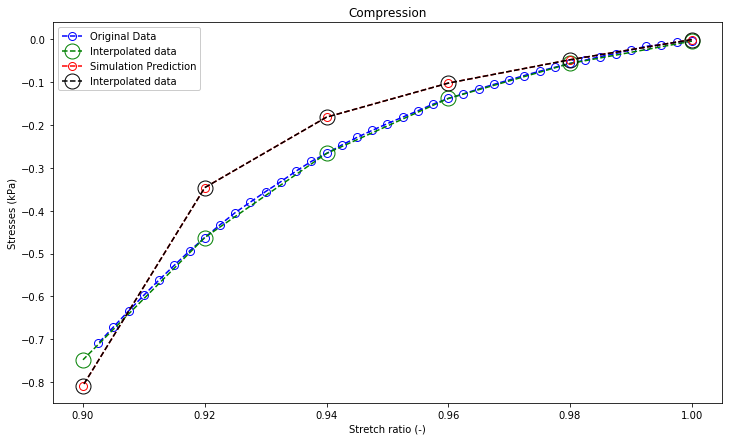

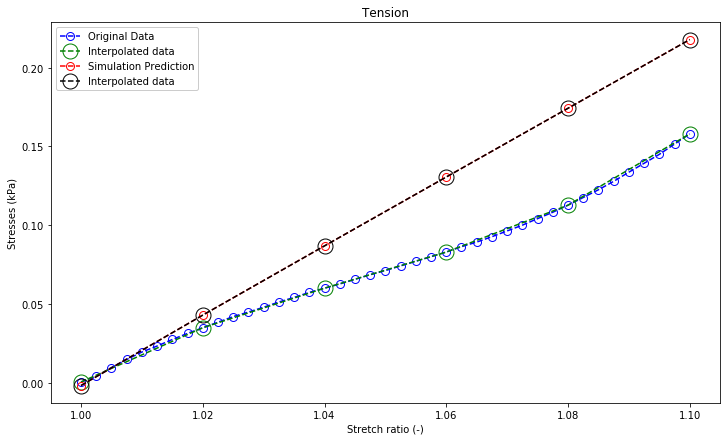

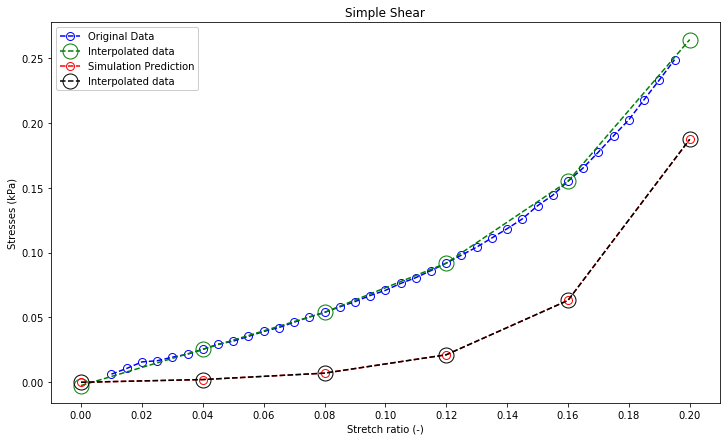

In [9]:
Nu = 0.49                             # (-)
# FinalRelativeStretch = 0.1
# RelativeStepSize     = 0.02
# Dimensions = [5,5,5]
# # Mu, Alpha = [0.6, -24.3]
# LoadCases = ['Compression','Tension','Simple Shear']
# LoadCases = ['Compression']
[Mu, Alpha] = ResOpt.x
OgdenCostFunction([ Mu, Alpha], Nu, LoadCases, FinalRelativeStretch, RelativeStepSize, Dimensions, Plot = True)

In [6]:
FinalRelativeStretch = 0.1
RelativeStepSize     = 0.02
Dimensions = [5,5,5]
LoadCases = ['Compression', 'Tension', 'Simple Shear']

ResOpt = OgdenOptimization(FinalRelativeStretch, RelativeStepSize, Dimensions)

Cost: 45.58901056790997
Cost: 50.8432846325591
Cost: 46.22292929981204
Cost: 41.18821340187636
Cost: 36.719522133662295
Cost: 36.18772443597255
Cost: 31.660265318582688
Cost: 24.245077948260676
Cost: 15.991108922732003
Cost: 12.808740443651176
Cost: 5.535787730639008
Cost: 0.601656436203477
Cost: 4.348098332913957
Cost: 1.3948030328768177
Cost: 8.39240080925795
Cost: 1.336541666189056
Cost: 7.5843636554759035
Cost: 0.27905615378725274
Cost: 0.5986711876219653
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Cost: 1.9446178441458193
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Cost: 0.2691925933656384
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time

In [10]:
ResOpt

 final_simplex: (array([[ 4.38583229e-02, -5.46673078e+01],
       [ 4.41257264e-02, -5.45822226e+01],
       [ 4.40474648e-02, -5.46437316e+01]]), array([0.05808721, 0.05808933, 0.05809088]))
           fun: 0.05808720916844387
       message: 'Optimization terminated successfully.'
          nfev: 92
           nit: 47
        status: 0
       success: True
             x: array([ 4.38583229e-02, -5.46673078e+01])